In [1]:
from airplane import Airplane
from receiver import Receiver

airplane1 = Airplane('782034',[120.128234,30.2141348],[115.86143245,28.750012],180,1564503340)
receiver1 = Receiver([114.122588,36.548925])
time_track1 =receiver1.fin_time_track(airplane1)
track1 = airplane1.gettrack()

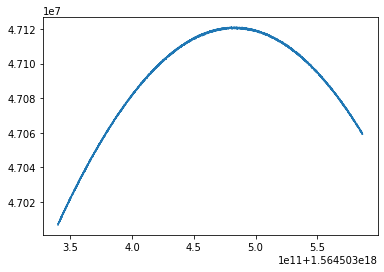

In [2]:
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt,pi, atan

using_data = time_track1
test_data = []

for i in range(len(using_data)-1):
    test_data.append(using_data[i+1]-using_data[i]-airplane1.geodistance(track1[i+1],receiver1.location)*10/3)

# plt.plot(using_data[19:79], test_data[19:79])
plt.plot(using_data[:-1], test_data)

# plt.ylim(0.39,0.6)
# plt.xlim(0.39,0.6)

plt.show()

In [3]:
# len(using_data)
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

test_data = torch.tensor(test_data[0:4800])
print(test_data)
test_size = 50
train_set = test_data[: -test_size]
test_set = test_data[-test_size:]

print(train_set)
print(test_set)


tensor([47006796., 47007132., 47007208.,  ..., 47067012., 47066956.,
        47066644.])
tensor([47006796., 47007132., 47007208.,  ..., 47069468., 47069672.,
        47069620.])
tensor([47069820., 47069512., 47069456., 47069404., 47069604., 47069296.,
        47069244., 47069188., 47069136., 47069080., 47069284., 47068972.,
        47068664., 47068864., 47068300., 47068756., 47068448., 47068392.,
        47068596., 47068796., 47068228., 47068176., 47068376., 47068324.,
        47068524., 47068216., 47068160., 47068104., 47068052., 47068252.,
        47067940., 47068144., 47067320., 47067780., 47067468., 47067668.,
        47067360., 47067560., 47067504., 47067196., 47067140., 47067084.,
        47067028., 47067232., 47067176., 47067376., 47066812., 47067012.,
        47066956., 47066644.])


In [37]:
print(len(train_set))
print(len(test_data))

4750
4800


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

train_set_array = np.array(train_set)
train_norm = sc.fit_transform(train_set_array.reshape(-1,1))
train_norm = torch.FloatTensor(train_norm).view(-1).to(device)

In [21]:
def input_data(seq,ws):
    out = []
    L = len(seq)

    for i in range(L-ws):
        window = seq[i : i+ws]
        label = seq[i+ws : i+ws+1]
        out.append((window,label))

    return out



window_size = 50
train_data = input_data(train_norm, window_size)
# print(train_data)
print(len(train_data))
print(train_data[0])

4700
(tensor([-1.0000, -0.9941, -0.9928, -0.9870, -0.9901, -0.9843, -0.9829, -0.9815,
        -0.9847, -0.9833, -0.9819, -0.9806, -0.9748, -0.9734, -0.9720, -0.9707,
        -0.9694, -0.9680, -0.9756, -0.9697, -0.9684, -0.9716, -0.9658, -0.9644,
        -0.9675, -0.9572, -0.9604, -0.9590, -0.9576, -0.9473, -0.9505, -0.9625,
        -0.9567, -0.9509, -0.9451, -0.9482, -0.9424, -0.9410, -0.9442, -0.9384,
        -0.9371, -0.9447, -0.9388, -0.9330, -0.9406, -0.9348, -0.9245, -0.9366,
        -0.9353, -0.9250], device='cuda:0'), tensor([-0.9192], device='cuda:0'))


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50,out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = ( torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred= self.linear(lstm_out.view(len(seq), -1))

        return pred[-1]


torch.manual_seed(42)
model = LSTM().cuda()
# train_data.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


print(model)


for p in model.parameters():
    print(p.numel())

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
200
10000
200
200
50
1


In [26]:
epochs = 50
future =50

for i in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1, model.hidden_size).cuda(), torch.zeros(1,1, model.hidden_size).cuda())
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    preds = train_set [-window_size:].tolist()

#     for f in range(future):
#         seq = torch.FloatTensor(preds [-window_size:])
#         with torch.no_grad():
#             model.hidden = (torch.zeros(1,1, model.hidden_size), torch.zeros(1,1, model.hidden_size))
#             preds.append(model(seq).item())
    
#     plt.figure(figsize=(12,4))
#     # plt.xlim(700,801)
#     plt.grid(True)
#     plt.plot(test_data.numpy())
#     plt.plot(range(4800,4850), preds[-window_size:])
#     plt.title("Forcasting based on the training data and compare with test data")
#     plt.show()
    

    print( f" Epoch {i} Loss:  {loss.item()}")

 Epoch 0 Loss:  0.0007358497241511941
 Epoch 1 Loss:  0.0005126437172293663
 Epoch 2 Loss:  0.0003237049968447536
 Epoch 3 Loss:  0.00018888966587837785
 Epoch 4 Loss:  0.00010507888509891927
 Epoch 5 Loss:  5.7769997511059046e-05
 Epoch 6 Loss:  3.2486088457517326e-05
 Epoch 7 Loss:  1.9220009562559426e-05
 Epoch 8 Loss:  1.2196337593195494e-05
 Epoch 9 Loss:  8.376007826882415e-06
 Epoch 10 Loss:  6.2212989178078715e-06
 Epoch 11 Loss:  4.957276814820943e-06
 Epoch 12 Loss:  4.18710760641261e-06
 Epoch 13 Loss:  3.700631850733771e-06
 Epoch 14 Loss:  3.3824580896180123e-06
 Epoch 15 Loss:  3.16716523229843e-06
 Epoch 16 Loss:  3.0159735615598038e-06
 Epoch 17 Loss:  2.905799874497461e-06
 Epoch 18 Loss:  2.821779617079301e-06
 Epoch 19 Loss:  2.755168907242478e-06
 Epoch 20 Loss:  2.699994411159423e-06
 Epoch 21 Loss:  2.6525808607402723e-06
 Epoch 22 Loss:  2.6104003154614475e-06
 Epoch 23 Loss:  2.572189032434835e-06
 Epoch 24 Loss:  2.5367271518916823e-06
 Epoch 25 Loss:  2.503137

In [51]:
future = 1000
preds = train_norm[1000:1050].tolist()

print(preds)
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())

# print(preds)

[0.14007568359375, 0.14544677734375, 0.15087890625, 0.142822265625, 0.148193359375, 0.14013671875, 0.1455078125, 0.15093994140625, 0.14727783203125, 0.148193359375, 0.14910888671875, 0.15447998046875, 0.1553955078125, 0.16082763671875, 0.15277099609375, 0.1580810546875, 0.1500244140625, 0.1553955078125, 0.16082763671875, 0.16619873046875, 0.15814208984375, 0.15899658203125, 0.16436767578125, 0.165283203125, 0.170654296875, 0.15362548828125, 0.15899658203125, 0.1688232421875, 0.16082763671875, 0.16168212890625, 0.16253662109375, 0.17242431640625, 0.17333984375, 0.17425537109375, 0.17510986328125, 0.1715087890625, 0.1768798828125, 0.177734375, 0.17864990234375, 0.1795654296875, 0.17144775390625, 0.18133544921875, 0.177734375, 0.18304443359375, 0.1839599609375, 0.180419921875, 0.18572998046875, 0.1866455078125, 0.1920166015625, 0.18389892578125]


In [54]:
predictions = sc.inverse_transform(np.array(preds[0:]).reshape(-1, 1))
# true = sc.inverse_transform(np.array(train_norm[50:1050]).reshape(-1, 1))

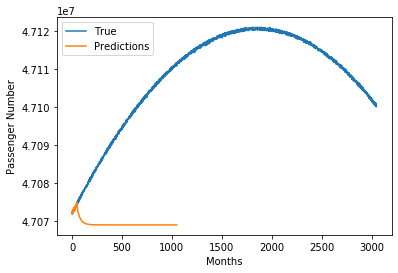

In [55]:
plt.plot(test_data[1000:4050],label='True')
plt.plot(predictions,label='Predictions')
plt.xlabel("Months")
plt.ylabel("Passenger Number");
plt.legend()

In [17]:
import pymysql

conn=pymysql.connect(host="47.95.200.134",port=3306,user="lzj",password="123.aaaAAA",database="ADSB",charset="utf8")
cursor=conn.cursor()
sql="select shiyanshi1.f_time,shiyanshi1.hp_time,shiyanshi1.longitude,shiyanshi1.latitude,shiyanshi1.icao \
    from shiyanshi1 order by shiyanshi1.icao,shiyanshi1.f_time,shiyanshi1.hp_time;"
# 获取多条查询数据
all_data = [] #[time1(ns),time2(ns),]
i=0
try:  
    cursor.execute(sql)    #执行sql语句  
    results = cursor.fetchall()    #获取查询的所有记录  
    for row in results :
        f_time1 = row[0]  
        hp_time1 = row[1]   
        
        all_data.append([])
        all_data[i].append(f_time1*1000000000+hp_time1)
        all_data[i].append(row[2])
        all_data[i].append(row[3])
        all_data[i].append(row[4])
        i+=1
        
    print("数据加载完成")
    print(len(all_data))
#     print(all_data[0:100])

except Exception as e:  
    raise e  
finally:  
    conn.close()  #关闭连接 

数据加载完成
76798


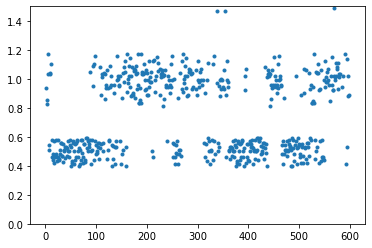

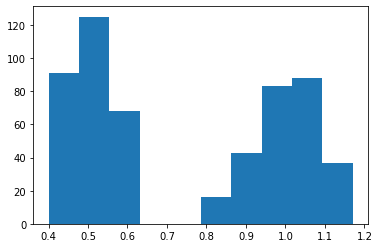

In [64]:
import matplotlib.pyplot as plt

using_data = []
for a in all_data:
    if a[3] == '750477':
        using_data.append(a[0]/1000000000)
using_data.sort()
test_data = []
for i in range(len(using_data)-1):
    test_data.append((using_data[i+1]-using_data[i]))

# plt.plot(using_data[19:79], test_data[19:79])
# plt.plot(using_data[70000:-1], test_data[70000:],'.')
plt.plot( test_data,'.')

plt.ylim(0,1.5)
# plt.xlim(0.39,0.6)

plt.show()

x= []
for a in test_data:
    if a<1.3:
        x.append(a)
plt.hist(x)
plt.show()

In [3]:
# from example.commons import Faker
from pyecharts import options as opts
from pyecharts.charts import Geo
from pyecharts.globals import ChartType, SymbolType


# 链式调用
c = (
    Geo()
    # 加载图表模型中的中国地图
    .add_schema(maptype="china")
    # 在地图中加入点的属性
    .add("geo", [list(z) for z in zip(Faker.provinces, Faker.values())])
    # 设置坐标属性
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    # 设置全局属性
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(),
        title_opts=opts.TitleOpts(title="Geo-基本示例"),
    )
)

# 在 html(浏览器) 中渲染图表
c.render()
# 在 Jupyter Notebook 中渲染图表
c.render_notebook()

ModuleNotFoundError: No module named 'pyecharts'

In [4]:
1.564503636754045e+18-1.5645036367040443e+18-0.5*100000000

640.0

In [7]:
import folium
# import pandas as pd

# define the world map
world_map = folium.Map()

# display world map
world_map

In [1]:
import torch

# torch.cuda()
print(torch.cuda.is_available())

False


In [4]:
from torch.backends import cudnn

cudnn.is_available()

True

In [5]:
cudnn.is_acceptable(a.cuda())

NameError: name 'a' is not defined

In [2]:
# Python 测试
import torch
# 若正常则静默
 
a = torch.tensor(1.)
# 若正常则静默
 
a.cuda()
# # 若正常则返回 tensor(1., device='cuda:0')
 
# from torch.backends import cudnn
# # 若正常则静默
 
# cudnn.is_available()
# # 若正常则返回 True
 
# cudnn.is_acceptable(a.cuda()) 
# 若正常则返回 True


RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /pytorch/aten/src/THC/THCGeneral.cpp:50